<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/%E5%8F%B0%E5%8C%96%E4%BA%8C%E9%83%A8_%E5%A6%82%E4%BD%95%E6%8F%90%E5%8D%87%E8%BD%89%E6%8F%9B%E7%8E%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from lightgbm import LGBMClassifier,LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score,mean_absolute_error
import xgboost
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier,XGBRegressor
from sklearn.svm import SVR
import lightgbm
from sklearn.metrics import f1_score,classification_report
import warnings;warnings.simplefilter('ignore')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
data = pd.read_excel('/content/drive/My Drive/台化二部/台化二部實驗數據_new/複本 操作與品管數據(20190723提供).xlsx')
data.head()

,Unnamed: 0,R141入口,Unnamed: 2,Unnamed: 3,Unnamed: 4,R141反應溫度,Unnamed: 6,Unnamed: 7,Unnamed: 8,R141入口.1,Unnamed: 10,品管數據,Unnamed: 12
0,NaN,新鮮苯流量(M3/h),DIPB流量(M3/h),溫度(℃),壓力(KGf/cm2 G),第一床(℃),第二床(℃),第三床(℃),第四床(℃),溫度(℃),壓力(KGf/cm2 G),ppm,%
1,DATE,PHL-DCS-FIC1147_PV,PHL-DCS-FIC1149A_PV,PHL-DCS-TIC1163_PV,PHL-DCS-PI1162_PV,PHL-DCS-TI1166_PV,PHL-DCS-TI1167_PV,PHL-DCS-TI1168_PV,PHL-DCS-TI1169_PV,PHL-DCS-TI1170_PV,PHL-DCS-PIC1166_PV,T121 EB含量,DIPB轉化率
2,2013-08-20 10:10:00,31.212,24.9928,169.894,NaN,167.057,166.569,166.279,165.041,NaN,12.297,NaN,NaN
3,2013-08-20 10:20:00,31.2236,25.0668,169.753,NaN,167.051,166.576,166.26,164.97,NaN,12.2914,NaN,NaN
4,2013-08-20 10:30:00,31.5726,25.163,169.526,NaN,167.042,166.584,166.235,164.877,NaN,12.3175,NaN,NaN


# 轉換成表格數據

In [0]:
def clean(data):
  data = data.dropna(how='all')
  columns = data.iloc[1,:]
  data = data.iloc[2:,:]
  data.columns = columns
  data = data.set_index('DATE')
  data.columns.name = None
  for col in data.columns:
    data[col] = pd.to_numeric(data[col],errors='coerce')
  return data

In [61]:
data = clean(data)
data.head()

,PHL-DCS-FIC1147_PV,PHL-DCS-FIC1149A_PV,PHL-DCS-TIC1163_PV,PHL-DCS-PI1162_PV,PHL-DCS-TI1166_PV,PHL-DCS-TI1167_PV,PHL-DCS-TI1168_PV,PHL-DCS-TI1169_PV,PHL-DCS-TI1170_PV,PHL-DCS-PIC1166_PV,T121 EB含量,DIPB轉化率
DATE,,,,,,,,,,,,
2013-08-20 10:10:00,31.212050,24.992781,169.893986,NaN,167.057086,166.569303,166.278953,165.041317,NaN,12.297010,NaN,NaN
2013-08-20 10:20:00,31.223557,25.066836,169.752653,NaN,167.050706,166.575684,166.259814,164.969540,NaN,12.291411,NaN,NaN
2013-08-20 10:30:00,31.572592,25.163049,169.525828,NaN,167.042458,166.583934,166.235069,164.876743,NaN,12.317545,NaN,NaN
2013-08-20 10:40:00,31.886214,25.136713,169.316875,NaN,167.034209,166.592183,166.210325,164.783946,NaN,12.317918,NaN,NaN
2013-08-20 10:50:00,31.855439,25.220729,169.665105,NaN,167.025961,166.600433,166.185580,164.691149,NaN,12.315540,NaN,NaN


In [0]:
features = data.drop(['DIPB轉化率'],axis=1).columns.tolist()
y_name = 'DIPB轉化率'

# 缺失

In [63]:
miss = pd.DataFrame(data.isnull().sum(),columns=['miss total'])
miss['miss total%'] = round(miss['miss total']/len(data),3)
miss.style.background_gradient()

,miss total,miss total%
PHL-DCS-FIC1147_PV,71,0.001
PHL-DCS-FIC1149A_PV,71,0.001
PHL-DCS-TIC1163_PV,71,0.001
PHL-DCS-PI1162_PV,47277,0.569
PHL-DCS-TI1166_PV,71,0.001
PHL-DCS-TI1167_PV,71,0.001
PHL-DCS-TI1168_PV,71,0.001
PHL-DCS-TI1169_PV,71,0.001
PHL-DCS-TI1170_PV,47276,0.569
PHL-DCS-PIC1166_PV,71,0.001


# 取樣時間

In [0]:
from collections import Counter

def get_time_step(col): 
  time = data[~data[col].isnull()].index
  delta = time[1:] - time[:-1]
  return Counter(delta).most_common(1)

In [73]:
for i in data.columns:
  print(i,get_time_step(i))

PHL-DCS-FIC1147_PV [(Timedelta('0 days 00:10:00'), 82953)]
PHL-DCS-FIC1149A_PV [(Timedelta('0 days 00:10:00'), 82953)]
PHL-DCS-TIC1163_PV [(Timedelta('0 days 00:10:00'), 82953)]
PHL-DCS-PI1162_PV [(Timedelta('0 days 00:10:00'), 35749)]
PHL-DCS-TI1166_PV [(Timedelta('0 days 00:10:00'), 82953)]
PHL-DCS-TI1167_PV [(Timedelta('0 days 00:10:00'), 82953)]
PHL-DCS-TI1168_PV [(Timedelta('0 days 00:10:00'), 82953)]
PHL-DCS-TI1169_PV [(Timedelta('0 days 00:10:00'), 82953)]
PHL-DCS-TI1170_PV [(Timedelta('0 days 00:10:00'), 35750)]
PHL-DCS-PIC1166_PV [(Timedelta('0 days 00:10:00'), 82953)]
T121 EB含量 [(Timedelta('0 days 08:00:00'), 1505)]
DIPB轉化率 [(Timedelta('1 days 00:00:00'), 478)]


# 統計資訊

In [74]:
data.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
PHL-DCS-FIC1147_PV,82957,33.274,11.0211,0.0305995,31.1159,35.1648,40.9854,52.7277
PHL-DCS-FIC1149A_PV,82957,22.7352,6.74096,0,24.1729,24.8027,25.4955,29.7189
PHL-DCS-TIC1163_PV,82957,165.898,16.8214,110.036,168.804,170.478,173.021,184.354
PHL-DCS-PI1162_PV,35751,14.4079,0.130853,7.40588,14.3798,14.4238,14.4401,15.1049
PHL-DCS-TI1166_PV,82957,157.729,36.0506,17.4919,165.681,167.544,170.294,182.3
PHL-DCS-TI1167_PV,82957,157.846,36.1358,17.2973,165.378,167.692,170.671,177.282
PHL-DCS-TI1168_PV,82957,157.635,36.0933,17.1474,165.01,167.44,170.388,187.304
PHL-DCS-TI1169_PV,82957,156.099,36.585,0,163.469,166.494,169.366,176.017
PHL-DCS-TI1170_PV,35752,164.57,6.07906,54.7927,164.389,165.373,166.366,173.644
PHL-DCS-PIC1166_PV,82957,11.3938,3.14274,0,12.2974,12.2997,12.3019,12.7299


# 視覺化探索數據

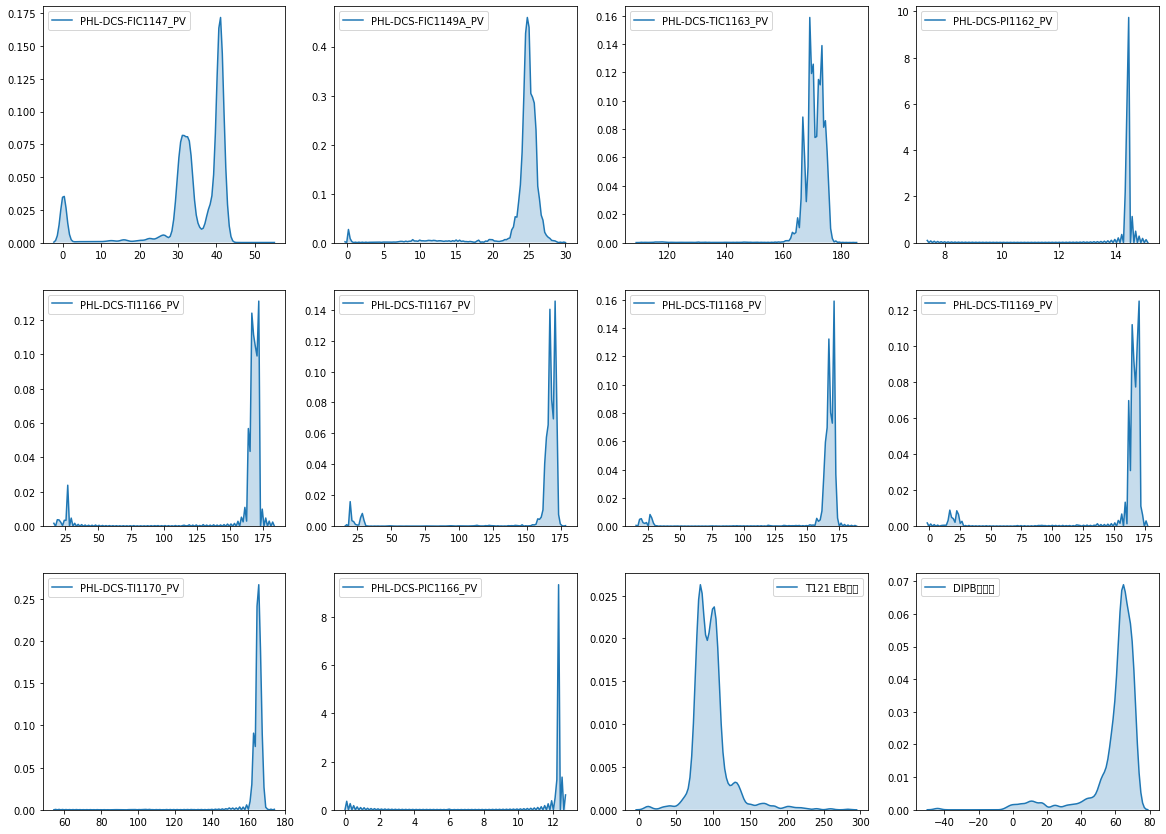

In [75]:
fig = plt.figure(figsize=(20,20))
for i,col in enumerate(data.columns):
  plt.subplot(4,4,i+1)
  sns.kdeplot(data[col],shade=True)
plt.show()

# scatter

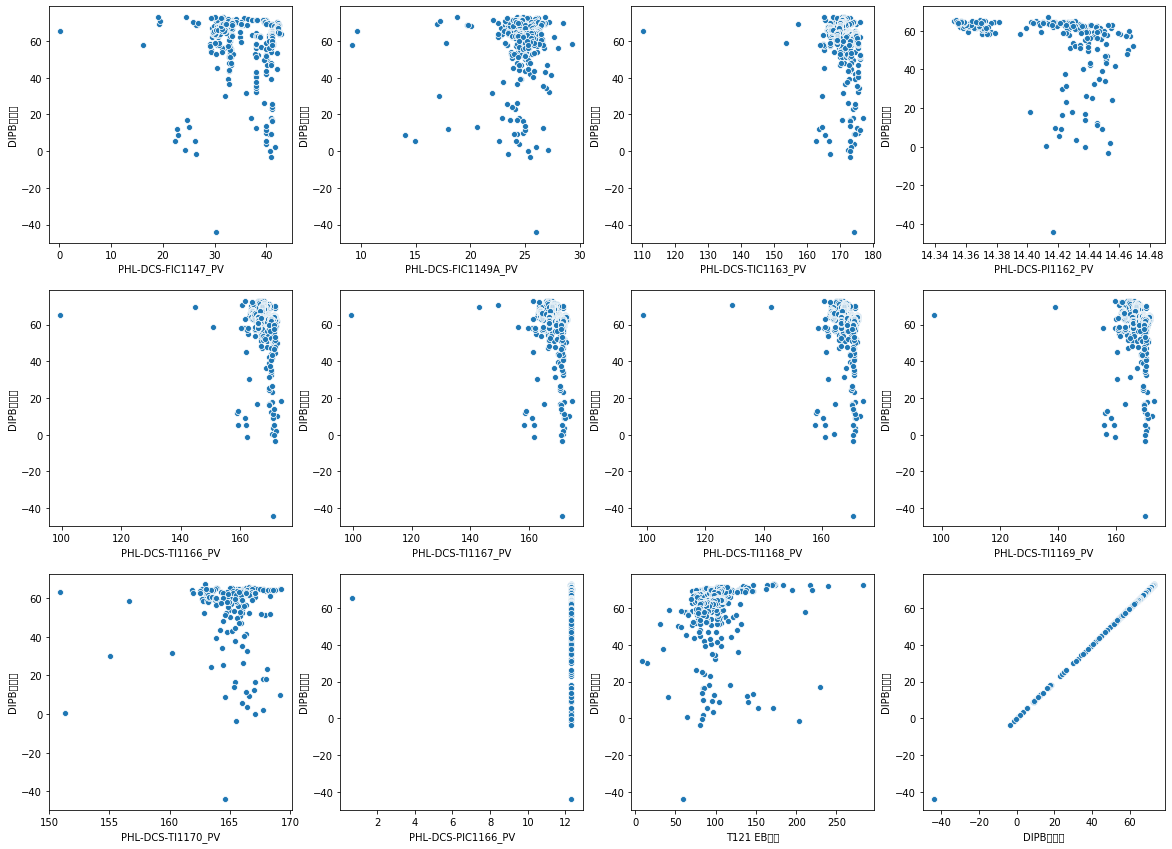

In [76]:
import seaborn as sns
fig = plt.figure(figsize=(20,20))
for i,col in enumerate(data.columns):
  plt.subplot(4,4,i+1)
  sns.scatterplot(x=col,y=y_name,data=data)
plt.show()

# corr

In [78]:
print('經過絕對值轉換')
abs(data.corr()).style.background_gradient(axis=1)

經過絕對值轉換


,PHL-DCS-FIC1147_PV,PHL-DCS-FIC1149A_PV,PHL-DCS-TIC1163_PV,PHL-DCS-PI1162_PV,PHL-DCS-TI1166_PV,PHL-DCS-TI1167_PV,PHL-DCS-TI1168_PV,PHL-DCS-TI1169_PV,PHL-DCS-TI1170_PV,PHL-DCS-PIC1166_PV,T121 EB含量,DIPB轉化率
PHL-DCS-FIC1147_PV,1,0.884923,0.89913,0.304174,0.849823,0.847297,0.841579,0.862173,0.73121,0.844226,0.23428,0.0443793
PHL-DCS-FIC1149A_PV,0.884923,1,0.934985,0.365651,0.877757,0.868036,0.859819,0.882931,0.683053,0.880731,0.0201724,0.121691
PHL-DCS-TIC1163_PV,0.89913,0.934985,1,0.350941,0.94357,0.932389,0.923426,0.939352,0.604921,0.947079,0.0629258,0.156108
PHL-DCS-PI1162_PV,0.304174,0.365651,0.350941,1,0.309391,0.262835,0.297407,0.274725,0.325315,0.962897,0.261149,0.321703
PHL-DCS-TI1166_PV,0.849823,0.877757,0.94357,0.309391,1,0.991727,0.984078,0.978121,0.648831,0.940254,0.0662891,0.128274
PHL-DCS-TI1167_PV,0.847297,0.868036,0.932389,0.262835,0.991727,1,0.994928,0.986913,0.689236,0.943591,0.082717,0.13459
PHL-DCS-TI1168_PV,0.841579,0.859819,0.923426,0.297407,0.984078,0.994928,1,0.991156,0.789451,0.941671,0.0921779,0.116291
PHL-DCS-TI1169_PV,0.862173,0.882931,0.939352,0.274725,0.978121,0.986913,0.991156,1,0.916927,0.959771,0.100037,0.096656
PHL-DCS-TI1170_PV,0.73121,0.683053,0.604921,0.325315,0.648831,0.689236,0.789451,0.916927,1,0.350758,0.291141,0.053617
PHL-DCS-PIC1166_PV,0.844226,0.880731,0.947079,0.962897,0.940254,0.943591,0.941671,0.959771,0.350758,1,0.0576365,0.0165576


# kdeplot

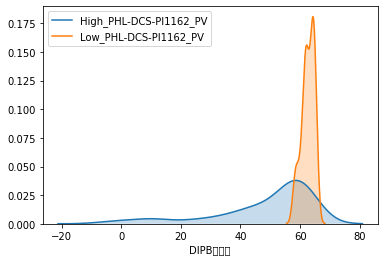

In [48]:
by_col = 'PHL-DCS-PI1162_PV'
c1 = data.loc[ data[by_col] > data[by_col].quantile(0.75) ,y_name]
c2 = data.loc[ data[by_col] < data[by_col].quantile(0.25) ,y_name]
plt.xlabel(y_name)
sns.kdeplot(c1,label='High_'+by_col,shade=True)
sns.kdeplot(c2,label='Low_'+by_col,shade=True)

# prepare data for modeling

In [49]:
data = data[features+[y_name]].dropna()
scaler_x = StandardScaler()
data[features] = scaler_x.fit_transform(data[features])
X = data[features]
y = data[y_name]
print(X.shape,y.shape)

(212, 11) (212,)


In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(148, 11) (148,)
(64, 11) (64,)


# modeling

In [0]:
def metric(yt,yp,name):
  res = {
      'R2':r2_score(yt,yp),
      'MAE':mean_absolute_error(yt,yp)}
  return pd.DataFrame(res,index=[name])

# xgb篩選因子

In [52]:
model = XGBRegressor()
model.fit(X_train,y_train)
xgb_imp = pd.DataFrame(dict(zip(features,model.feature_importances_)),index=['importance']).T.sort_values(by='importance',ascending=False)
xgb_imp

[06:00:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,importance
PHL-DCS-TI1166_PV,0.213183
T121 EB含量,0.159753
PHL-DCS-FIC1147_PV,0.155947
PHL-DCS-PI1162_PV,0.092923
PHL-DCS-TI1170_PV,0.091214
PHL-DCS-FIC1149A_PV,0.069403
PHL-DCS-TIC1163_PV,0.062823
PHL-DCS-TI1169_PV,0.047910
PHL-DCS-PIC1166_PV,0.047001
PHL-DCS-TI1167_PV,0.035402


# Lasso篩選因子

In [53]:
model = Lasso()
model.fit(X_train,y_train)
Lasso_coef = pd.DataFrame(dict(zip(features,model.coef_)),index=['coef']).T.sort_values(by='coef',ascending=False)
Lasso_coef

,coef
PHL-DCS-FIC1147_PV,5.971755
T121 EB含量,2.274328
PHL-DCS-FIC1149A_PV,0.000000
PHL-DCS-TI1167_PV,-0.000000
PHL-DCS-TI1168_PV,-0.000000
PHL-DCS-TI1169_PV,-0.000000
PHL-DCS-TI1170_PV,-0.000000
PHL-DCS-PI1162_PV,-1.066890
PHL-DCS-PIC1166_PV,-1.083139
PHL-DCS-TI1166_PV,-1.580258


# modeling

In [54]:
selected_features = list(xgb_imp.head(5).index)
print('使用xgb篩選特徵:',selected_features)

model = XGBRegressor(objective='reg:squarederror')
model.fit(X_train[selected_features],y_train)
metric(y_train,model.predict(X_train[selected_features]),'train').append(metric(y_test,model.predict(X_test[selected_features]),'test'))

使用xgb篩選特徵: ['PHL-DCS-TI1166_PV', 'T121 EB含量', 'PHL-DCS-FIC1147_PV', 'PHL-DCS-PI1162_PV', 'PHL-DCS-TI1170_PV']


,R2,MAE
train,0.956217,2.389369
test,0.134230,8.605164


In [55]:
selected_features = list(Lasso_coef.loc[Lasso_coef['coef']!=0].index)
print('使用Lasso篩選特徵:',selected_features)

model = Lasso()
model.fit(X_train[selected_features],y_train)
metric(y_train,model.predict(X_train[selected_features]),'train').append(metric(y_test,model.predict(X_test[selected_features]),'test'))

使用Lasso篩選特徵: ['PHL-DCS-FIC1147_PV', 'T121 EB含量', 'PHL-DCS-PI1162_PV', 'PHL-DCS-PIC1166_PV', 'PHL-DCS-TI1166_PV', 'PHL-DCS-TIC1163_PV']


,R2,MAE
train,0.335653,8.937764
test,0.178649,9.046643
